### The OpenEye tools can handle conversions and parsing of SMILES
As we already saw in the 3D structure/shape lecture (to a limited extent) the OpenEye tools can work with common molecular file formats, but also with chemical names AND with SMILES strings. 

We previously saw (in the 3D structure/shape iPython notebook) that we can create molecules from their names or SMILES strings. Let's recap that, and *also* see how to generate SMILES strings for molecules we already have, and IUPAC names for molecules we already have

In [ ]:
# Run cell if using collab

# Import condacolab python library and install condacolab (~5 minutes). 
# Rerun cell after crashing
!pip install --target=$nb_path -q condacolab
import condacolab
condacolab.install()

#check condacolab to ensure that it works
condacolab.check()

#other installs
!conda install -c conda-forge nb_conda nglview py3dmol mdtraj --yes 
!conda install -c openeye openeye-toolkits --yes
!pip install --extra-index-url https://pypi.org/simple --extra-index-url https://pypi.anaconda.org/openeye/simple/ -i https://pypi.anaconda.org/openeye/label/oenotebook/simple openeye-oenotebook

In [ ]:
# Run cell if using collab

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
# Run cell if using collab

# Link openeye license to .bash_profile  
%%shell 
echo export OE_LICENSE="/content/drive/MyDrive/drug-computing/oelicense/oe_license.txt" >> ~/.bash_profile
source ~/.bash_profile

In [ ]:
# Run cell if using collab

#set the OE_LICENSE environment variable to point to the license file
%env OE_LICENSE=/content/drive/MyDrive/drug-computing/oelicense/oe_license.txt
# Check the OE_LICENSE environment variable set
%env

In [1]:
from openeye.oechem import *
from openeye.oeiupac import *

#Create a new empty molecule
mol = OEMol()
#Parse this IUPAC name into the molecule
OEParseIUPACName(mol, '1-cyclopropyl-6-fluoro-4-oxo-7-piperazin-1-yl-quinoline-3-carboxylic acid')
#OEParseIUPACName(mol, 'ibuprofen')

#Create an IUPAC name AND canonical SMILES string for this molecule
name = OECreateIUPACName(mol)
smi = OECreateCanSmiString(mol)
print( "Molecule 1 is %s and has smiles %s" % (name, smi) )

#Let's create another molecule from SMILES and get its name
mol2 = OEMol()
OEParseSmiles( mol2, 'C1CCCCC1')
print("Created molecule 2 from SMILES. It's called %s" % OECreateIUPACName(mol2))

Molecule 1 is 1-cyclopropyl-6-fluoro-4-oxo-7-piperazin-1-yl-quinoline-3-carboxylic acid and has smiles c1c2c(cc(c1F)N3CCNCC3)n(cc(c2=O)C(=O)O)C4CC4
Created molecule 2 from SMILES. It's called cyclohexane


The same approach will apply if you want to generate a name or SMILES from a molecule you read from a file. Specifically, you would first read in the molecule to an `OEMol` object or similar (as seen several times already, including in the 3D Structure/Shape lecture) and then simply run the relevant function (`OEParseIUPACName`, `OECreateCanSmiString`) on your molecule object.

# We can also visualize our molecule here using OEDepict
We can easily write it out to an image file, here `test.png`. Conveniently, iPython notebooks can display images, so we can also display that image inline here by reading it from the file. 

In [2]:
from openeye.oedepict import *
OEPrepareDepiction(mol)
OERenderMolecule('test.png', mol)
#If your molecule already has explicit hydrogens, you may wish to suppress all of these except polar hydrogens
#as described here: http://docs.eyesopen.com/toolkits/cookbook/python/depiction/polarhydrogens.html

True

### Display the image:

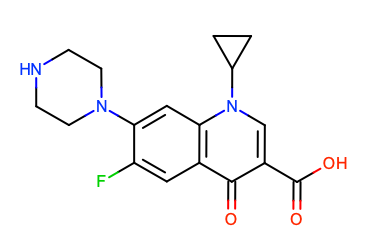

In [3]:
from IPython.display import Image
Image('test.png',width = 300)




### OpenEye's `oenotebook` toolkit interfaces with Jupyter notebooks to display molecules

This is super easy as long as you are inside a Jupyter notebook (see [the OpenEye notebook examples](https://www.eyesopen.com/notebooks-directory) for more related examples).

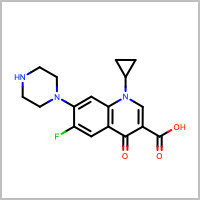

In [4]:
import oenotebook as oenb
oenb.draw_mol(mol)


### ChemDraw and Marvin and other viewers can handle a lot of the same tasks just performed here
They can typically handle generating names for molecules, or generating molecules from names, and SMILES strings can also be generated for molecules or vise versa. Here, however, we'll focus on using the OpenEye toolkits. Other chemical toolkits also should have similar features in general. Markdown can also be used to display images. 

# A technical note on the uniqueness of SMILES, and handling chiral compounds
## SMILES in general are not unique
In general, there is NOT a 1-1 correspondence between a SMILES string and a molecule. Rather, several SMILES strings can typically be written which correspond to the same chemical compound. Normally this is helpful, as the user wishing to specify a compound doesn't have to provide the *right* SMILES in order to identify the molecule they want. This also makes sense when we consider chemical names, which have a similar property (several names may correspond to one compound).

## Sometimes this non-uniqueness is undesirable
Suppose you're faced with a large corporate compound library and you want to apply some method to select a portion of this for experimental follow-up. However, you're aware that there may be duplicate compounds (under different names or identifiers) in the library. How do you check for (and rule out) these duplicates so your experimental group doesn't involve running duplicate assays except when they want to? You can't use SMILES OR names since neither of these corresponds 1-1 to particular molecules.

However, there is a fix - a *canonical SMILES string*, which is basically a standardized way of writing SMILES strings. OpenEye's tools can assign these (and in fact that's what we generated above -- canonical SMILES strings) to molecules, and they DO have a 1-1 correspondence to particular compounds. So if you create canonical SMILES strings for all of your compounds, you can then check that these are unique within your set, and filter out duplicates.

## Chirality poses another hurdle for SMILES

Standard SMILES strings do not denote molecular chirality. This is a major limitation, since it would prevent a 1-1 correspondence between SMILES and molecules for all chiral molecules AND it would prevent SMILES strings from uniquely identifying particular isomers or enantiomers of chiral compounds. Fortunately, there is a solution -- *isomeric* SMILES strings, which clearly indicate the chirality/isomeric state of the specified molecule.

Here is an example of ofloxacin, an antibacterial drug with one particular isomer which is more active than the other. Specifically, levofloxacin is more active/effective than ofloxacin (which is a racemic mixture of the two isomers). Let's generate both from their names and compare SMILES strings.

Note that chirality around tetrahedral centers is shown with the `@` symbol once or twice. 

CC1COc2c3n1cc(c(=O)c3cc(c2N4CCN(CC4)C)F)C(=O)O
CC1COc2c3n1cc(c(=O)c3cc(c2N4CCN(CC4)C)F)C(=O)O
C[C@H]1COc2c3n1cc(c(=O)c3cc(c2N4CCN(CC4)C)F)C(=O)O


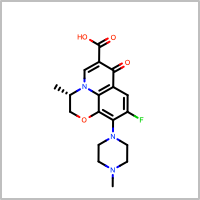

In [5]:
#Create a new molecule for ofloxacin
mol = OEMol()
#Generate ofloxacin
OEParseIUPACName( mol, 'ofloxacin')
#Print canonical and isomeric smiles - which are the same in this case since no isomer is specified.
print(OECreateCanSmiString(mol))
print(OECreateIsoSmiString(mol))

#Create a new molecule for levofloxacin
mol2 = OEMol()
#Generate levofloxacin
OEParseIUPACName(mol2,'levofloxacin')
#Print isomeric SMILES string which should now be different
print(OECreateIsoSmiString(mol2))

oenb.draw_mol(mol2)


### We should also address orientation at double bonds
It's also important to note that orientation at double bonds is handled with /, as in the following example

In [6]:
#Here, we look at cis- vs trans-difluoroethene
mol3 = OEMol()
OEParseSmiles( mol3, 'F/C=C/F')
mol4 = OEMol()
OEParseSmiles( mol4, 'F/C=C\F')
print("Mol3:", OECreateCanSmiString(mol3), OECreateIsoSmiString(mol3))
print("Mol4:", OECreateCanSmiString(mol4), OECreateIsoSmiString(mol4))
OEPrepareDepiction(mol3)
OERenderMolecule('test3.png', mol3)
OEPrepareDepiction(mol4)
OERenderMolecule('test4.png', mol4)

Mol3: C(=CF)F C(=C/F)\F
Mol4: C(=CF)F C(=C\F)\F


True

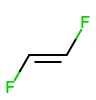

In [7]:
Image('test3.png', width = 150) 

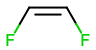

In [8]:
Image('test4.png', width = 150) 

# Lingo comparisons are a great tool for searching databases quickly
Here let's look at a very simple/quick Lingo comparison:

In [9]:
#Initialize two OE molecules
mol1 = OEMol()
mol2 = OEMol()

#Load compounds by their names
OEParseIUPACName(mol1, '')
OEParseIUPACName(mol2, 'caffeine')

#Initialize a lingo search object with molecule 1 as the query
lingo = OELingoSim(mol1)

#Apply lingo to calculat the similarity (0 to 1 range) of molecule 2
sim = lingo.Similarity(mol2)
#Print result
print(sim)

0.0


## Next, let's see use this to search a "mini-database" of compounds.
Here we'll just make up a query molecule and a list of molecules we want to compare it to, and find the most similar compounds (those meeting some similarity threshold).

In [10]:
#Initialize our query molecule
mol1 = OEMol()
queryname = 'benzoic acid'
#queryname = 'dopamine'
OEParseIUPACName(mol1, queryname)

#Set up our lingo search based on the query
lingo = OELingoSim(mol1)

#Specify a cutoff we'll use for filtering
cutoff = 0.3

#Specify our database - what compounds do we want to look at?
names = ['tylenol', 'phenol', 'toluene', 'benzene', 'naphthalene', 'ibuprofen', 'naproxen', 'acetic acid', 'ammonia', 'biphenyl']

# Optionally add some from SMILES
#smiles = ['c1ccccc1OCCNO']
#addlnames = []
#mol = OEMol()
#for smi in smiles:
#    OEParseSmiles(mol, smi)
#    addlnames.append( OECreateIUPACName(mol))
#names += addlnames

#Loop over our "database" and do our lingo comparison/search
for name in names:
    #Initialize this molecule
    mol2 = OEMol()
    OEParseIUPACName(mol2, name)
    #Do our lingo comparison
    sim = lingo.Similarity(mol2)
    
    #Check and see if it is a match; if so, do something
    if sim > cutoff:
        print("Similarity of %s to %s is %.2f" % (queryname, name, sim))
        #More generally, you could dump image files of all molecules matching, or write them out to a file, or...

Similarity of benzoic acid to tylenol is 0.47
Similarity of benzoic acid to phenol is 0.50
Similarity of benzoic acid to ibuprofen is 0.57
Similarity of benzoic acid to biphenyl is 0.33
